**Step 1: Data Preparation**

  1. **Download COVID-19 Data**
    
      Fetch the dataset from OWID.

  2. **Filter Data for China and the US**
    
      Use the `location` column to extract data for `China` and `United States`. Focus on:
        + `new_cases`
        + `new_deaths`
        + `stringency_index`

  3. **Supplement with Policy Data**
  
      + For China: Collect data on lockdowns, mass testing, and zero-COVID strategies.
      + For the US: Collect data on federal/state-level measures, vaccination rollouts, and public health mandates.
      + Use sources like government websites and the Oxford COVID-19 Government Response Tracker (OxCGRT).

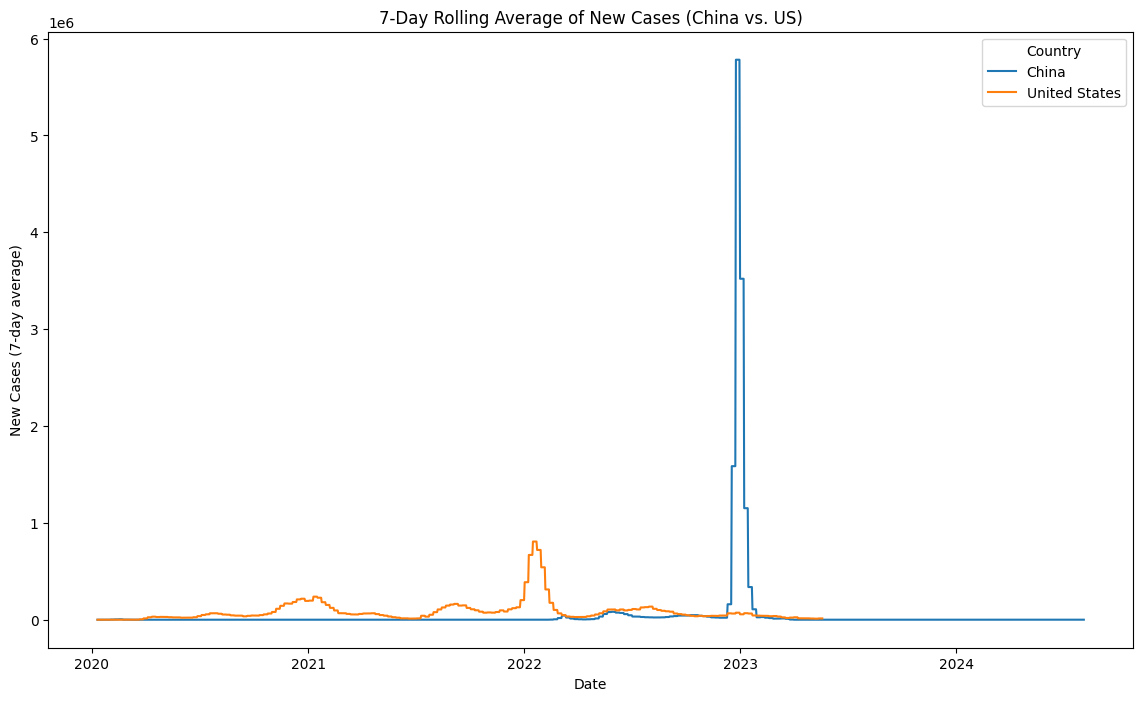

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load COVID-19 data
covid_data = pd.read_csv("owid-covid-data.csv")

# Filter for China and US
countries = ["China", "United States"]
df = covid_data[covid_data['location'].isin(countries)]

# Focus on relevant columns
df = df[["date", "location", "new_cases", "new_deaths", "stringency_index"]]
df['date'] = pd.to_datetime(df['date'])

# Rolling averages
df['new_cases_7day'] = df.groupby('location')['new_cases'].transform(lambda x: x.rolling(7).mean())
df['new_deaths_7day'] = df.groupby('location')['new_deaths'].transform(lambda x: x.rolling(7).mean())

# Plot trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x='date', y='new_cases_7day', hue='location')
plt.title("7-Day Rolling Average of New Cases (China vs. US)")
plt.xlabel("Date")
plt.ylabel("New Cases (7-day average)")
plt.legend(title="Country")
plt.show()


**Step 4: Advanced Integration of Policy Data**

**1. Load and Merge Data**

  + **COVID-19 Data:** Use the OWID dataset for cases and deaths.
  + **Policy Data:** Use the `OxCGRT_compact_national_v1.csv` for `stringency_index` and relevant policy indicators.
  + **Vaccination Data:** Use `OxCGRT_vaccines_full_national_v1.csv` for vaccination metrics like `total_vaccinations_per_hundred`.

**Steps for Data Merging:**

  1. **Filter and Align Dates:** Ensure the `date` columns in all datasets are in the same format (`YYYY-MM-DD`).
  2. **Merge Datasets:** Use `location` and `date` as keys for merging OWID, policy, and vaccination data.
  3. **Focus on Relevant Metrics: Extract:**
      + COVID-19: `new_cases`, `new_deaths`
      + Policies: `stringency_index`, key policy flags (e.g., school closures, workplace closures)
      + Vaccination: `total_vaccinations_per_hundred`

In [2]:
# Load datasets
covid_data = pd.read_csv("owid-covid-data.csv", parse_dates=["date"])
policy_data = pd.read_csv("OxCGRT_compact_national_v1.csv", parse_dates=["Date"])
vaccination_data = pd.read_csv("OxCGRT_vaccines_full_national_v1.csv", parse_dates=["Date"])

# Filter for China and US
countries = ["China", "United States"]
covid_data = covid_data[covid_data["location"].isin(countries)]
policy_data = policy_data[policy_data["CountryName"].isin(countries)]
vaccination_data = vaccination_data[vaccination_data["CountryName"].isin(countries)]

# Rename columns for consistency
policy_data.rename(columns={"Date": "date", "CountryName": "location"}, inplace=True)
vaccination_data.rename(columns={"Date": "date", "CountryName": "location"}, inplace=True)

# Merge datasets
merged_data = pd.merge(covid_data, policy_data, on=["location", "date"], how="inner")
merged_data = pd.merge(merged_data, vaccination_data, on=["location", "date"], how="inner")

# Focus on relevant columns
merged_data = merged_data[
    ["date", "location", "new_cases", "new_deaths", "stringency_index", 
     "total_vaccinations_per_hundred"]
]


**Step 5: Advanced Visualizations**

**1. Timeline with Policy Annotations**

Create line plots of `new_cases` and `new_deaths` over time, annotated with significant policy changes.

Example (China's early lockdown and US vaccination campaign):

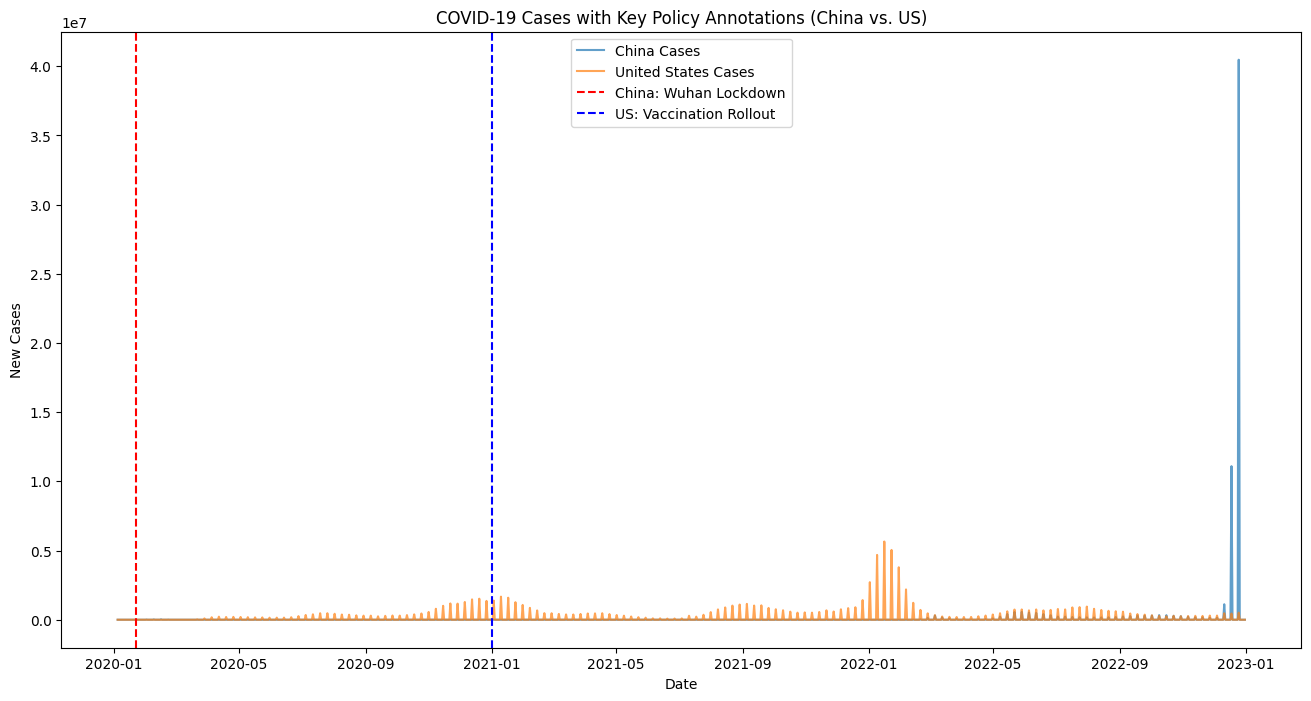

In [3]:
plt.figure(figsize=(16, 8))

for country in countries:
    subset = merged_data[merged_data["location"] == country]
    plt.plot(subset["date"], subset["new_cases"], label=f"{country} Cases", alpha=0.7)

# Annotate key policies
plt.axvline(pd.Timestamp("2020-01-23"), color="red", linestyle="--", label="China: Wuhan Lockdown")
plt.axvline(pd.Timestamp("2021-01-01"), color="blue", linestyle="--", label="US: Vaccination Rollout")

plt.title("COVID-19 Cases with Key Policy Annotations (China vs. US)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.show()


**2. Policy Stringency vs. Cases/Deaths**

  Scatter or line plot showing `stringency_index` against `new_cases`. Correlation can also be calculated:

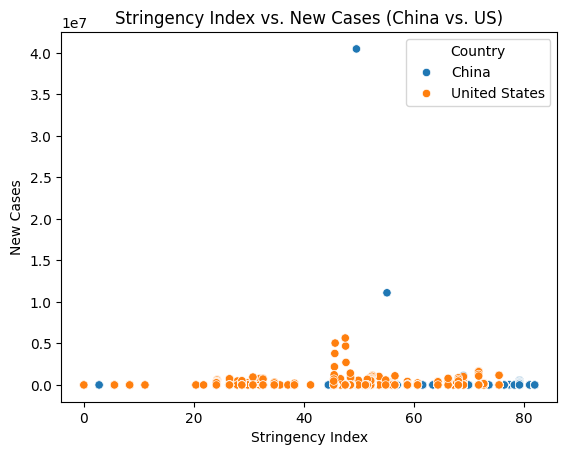

                                stringency_index  new_cases
location                                                   
China         stringency_index          1.000000  -0.066279
              new_cases                -0.066279   1.000000
United States stringency_index          1.000000   0.031789
              new_cases                 0.031789   1.000000


In [4]:
sns.scatterplot(data=merged_data, x="stringency_index", y="new_cases", hue="location")
plt.title("Stringency Index vs. New Cases (China vs. US)")
plt.xlabel("Stringency Index")
plt.ylabel("New Cases")
plt.legend(title="Country")
plt.show()

# Calculate correlation
correlation = merged_data.groupby("location")[["stringency_index", "new_cases"]].corr()
print(correlation)


**3. Comparative Metrics**

  Use bar plots to compare total cases, deaths, and vaccination rates per million for both countries.

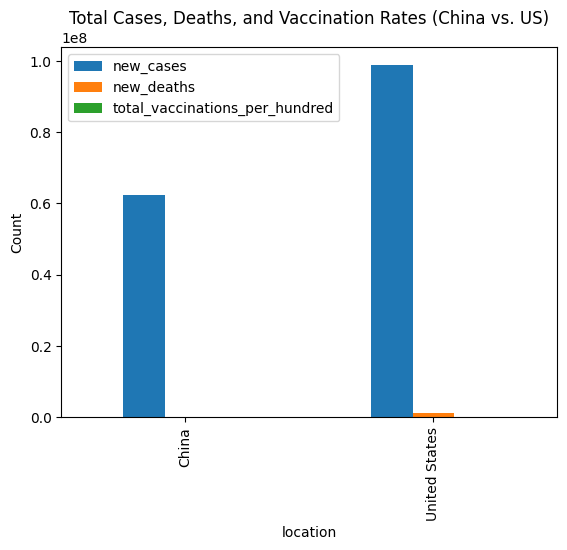

In [5]:
# Summarize metrics
summary = merged_data.groupby("location").agg({
    "new_cases": "sum",
    "new_deaths": "sum",
    "total_vaccinations_per_hundred": "max"
}).reset_index()

summary.plot(kind="bar", x="location", y=["new_cases", "new_deaths", "total_vaccinations_per_hundred"])
plt.title("Total Cases, Deaths, and Vaccination Rates (China vs. US)")
plt.ylabel("Count")
plt.show()


**4. Vaccination Impact**

  Dual-axis plot of vaccination rates and new cases:

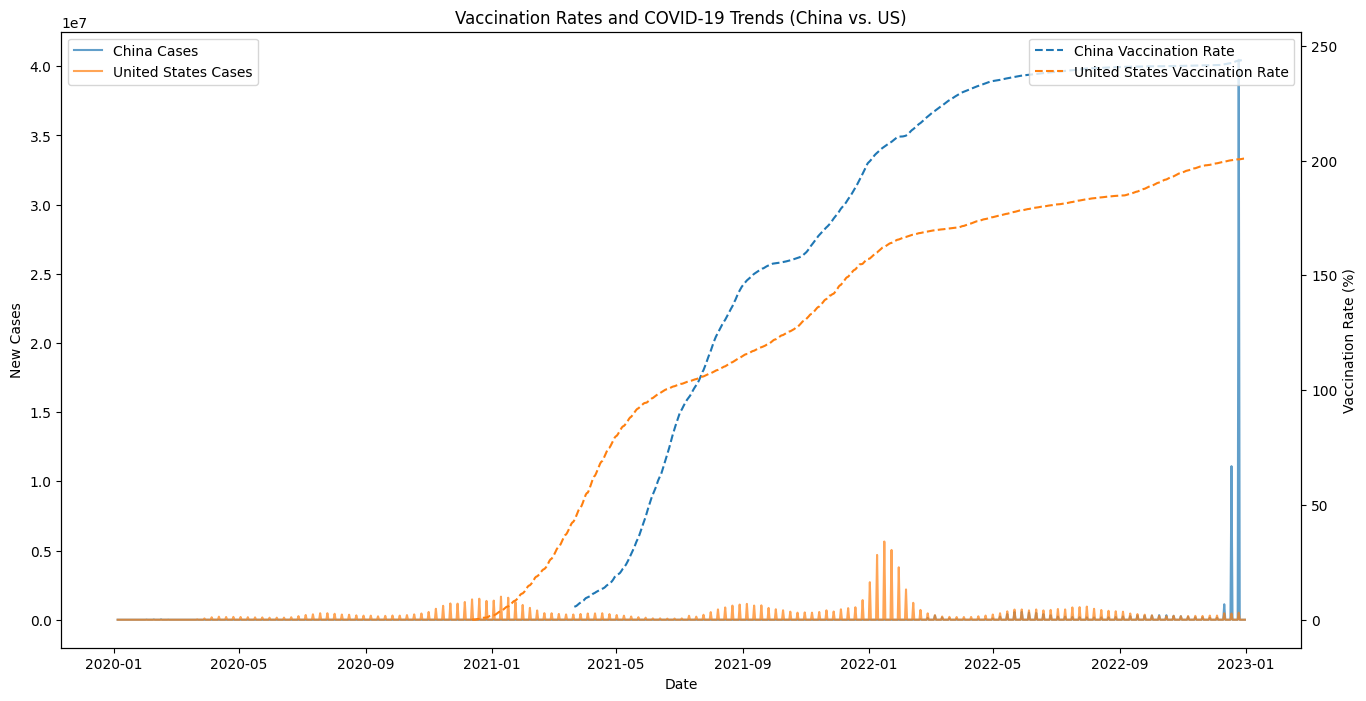

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot cases
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    ax1.plot(subset["date"], subset["new_cases"], label=f"{country} Cases", alpha=0.7)

# Plot vaccination rates
ax2 = ax1.twinx()
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    ax2.plot(subset["date"], subset["total_vaccinations_per_hundred"], label=f"{country} Vaccination Rate", linestyle="--")

ax1.set_title("Vaccination Rates and COVID-19 Trends (China vs. US)")
ax1.set_xlabel("Date")
ax1.set_ylabel("New Cases")
ax2.set_ylabel("Vaccination Rate (%)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


**Step 6: Key Metrics and Insights**

**Statistical Analysis**

  + Correlation between `stringency_index` and `new_cases/new_deaths` for both countries:

In [7]:
correlations = merged_data.groupby("location").apply(
    lambda x: x[["stringency_index", "new_cases", "new_deaths"]].corr()
)
print(correlations)


                                stringency_index  new_cases  new_deaths
location                                                               
China         stringency_index          1.000000  -0.066279   -0.014867
              new_cases                -0.066279   1.000000    0.783255
              new_deaths               -0.014867   0.783255    1.000000
United States stringency_index          1.000000   0.031789    0.144222
              new_cases                 0.031789   1.000000    0.717441
              new_deaths                0.144222   0.717441    1.000000


D:\TEMP\ipykernel_19828\1186250225.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = merged_data.groupby("location").apply(


Insights:

  + China:
    - Strict early lockdown and Zero-COVID policies minimized cases and deaths but prolonged social restrictions.
    - Vaccination rollout began later but was widespread.

  + US:
    - Delayed lockdown measures led to higher initial case counts.
    - Vaccination campaigns dramatically reduced deaths during subsequent waves.
    - Decentralized policies caused variation in outcomes across states.

1. Advanced Statistical Models

    **Regression Models for Policies and COVID Outcomes**

    To analyze the impact of policies (`stringency_index`) and vaccination rates on COVID cases and deaths:

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare data for regression
features = ["stringency_index", "total_vaccinations_per_hundred"]
target_cases = "new_cases"
target_deaths = "new_deaths"

for target in [target_cases, target_deaths]:
    # Combine features and target into a single DataFrame
    data = merged_data[features + [target]].dropna()  # Drop rows with any NaN values
    X = data[features]
    y = data[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(f"\nTarget: {target}")
    print(f"R^2 Score: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.4f}")
    print(f"Coefficients: {dict(zip(features, model.coef_))}")



Target: new_cases
R^2 Score: -0.0670
RMSE: 350060.9175
Coefficients: {'stringency_index': np.float64(-2494.6913536456404), 'total_vaccinations_per_hundred': np.float64(689.1561814522986)}

Target: new_deaths
R^2 Score: 0.0284
RMSE: 2479.3308
Coefficients: {'stringency_index': np.float64(-8.343066728685177), 'total_vaccinations_per_hundred': np.float64(-4.981284452989822)}


d:\Anaconda3\envs\4347\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
d:\Anaconda3\envs\4347\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2. Advanced Visualizations

  + **Heatmap of Stringency vs. Cases/Deaths Over Time**

    Heatmaps can show how stringency levels correlate with COVID cases/deaths over time.

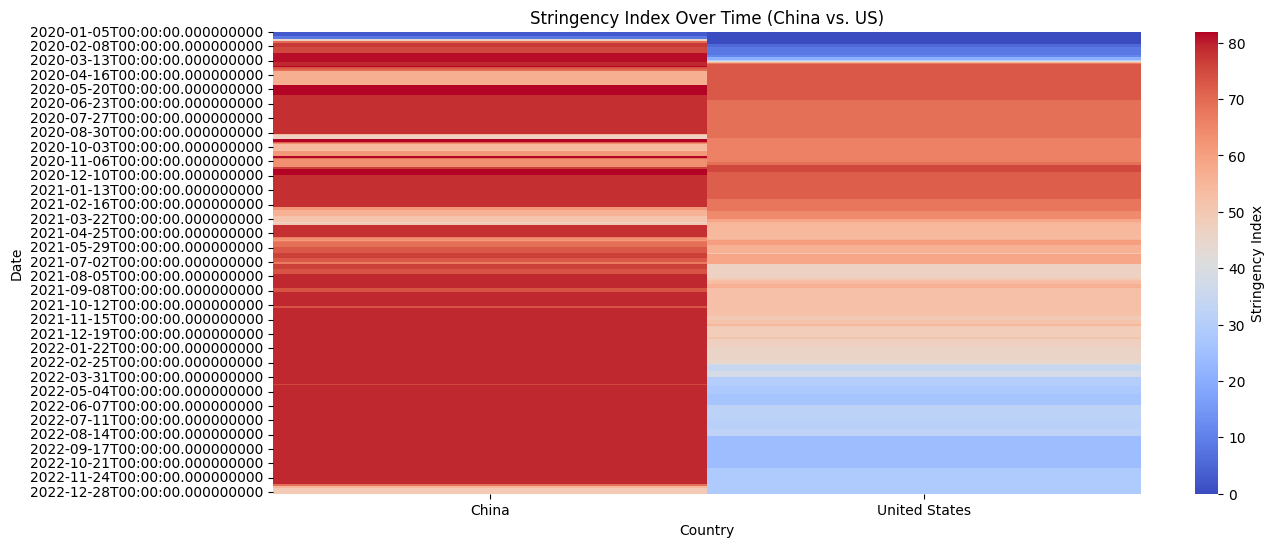

In [10]:
import seaborn as sns

# Pivot data
heatmap_data = merged_data.pivot_table(index="date", columns="location", values="stringency_index")

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", cbar_kws={"label": "Stringency Index"})
plt.title("Stringency Index Over Time (China vs. US)")
plt.xlabel("Country")
plt.ylabel("Date")
plt.show()


  + **Time-Series Decomposition**

    Break down `new_cases` into trend, seasonality, and residual components to better understand temporal patterns.

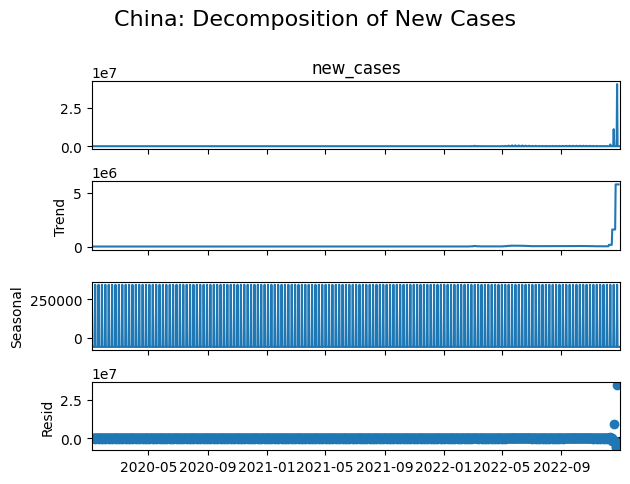

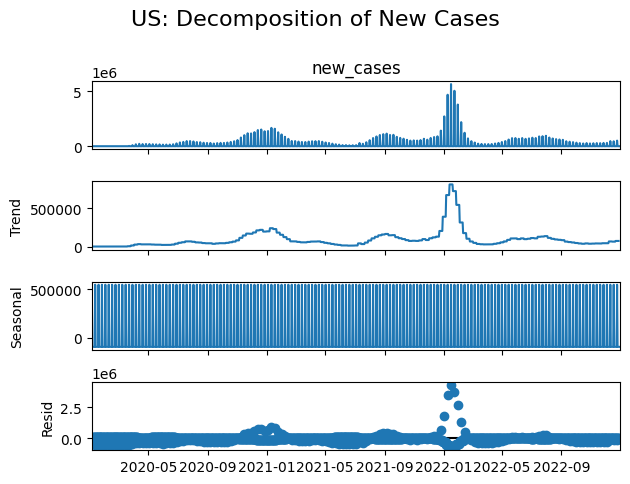

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose for China
china_data = merged_data[merged_data["location"] == "China"].set_index("date")
us_data = merged_data[merged_data["location"] == "United States"].set_index("date")

for country, data in [("China", china_data), ("US", us_data)]:
    # Decompose the data
    decomposition = seasonal_decompose(data["new_cases"].fillna(0), model="additive", period=7)
    
    # Plot the decomposition
    decomposition.plot()
    
    # Adjust the title and plot layout
    plt.suptitle(f"{country}: Decomposition of New Cases", fontsize=16, y=1)  # Adjust title's position
    plt.subplots_adjust(top=0.85)  # Move the title up a bit
    
    # Show the plot
    plt.show()


3. Additional Insights

    **Peak Analysis**

    Identify specific dates of peaks in cases and deaths for each country and relate them to stringency and vaccination rates.

In [28]:
for country in countries:
    subset = merged_data[merged_data["location"] == country]
    peak_cases_date = subset.loc[subset["new_cases"].idxmax(), "date"]
    peak_deaths_date = subset.loc[subset["new_deaths"].idxmax(), "date"]
    stringency_peak_cases = subset.loc[subset["new_cases"].idxmax(), "stringency_index"]
    stringency_peak_deaths = subset.loc[subset["new_deaths"].idxmax(), "stringency_index"]
    print(f"\n{country}:")
    print(f"Peak Cases Date: {peak_cases_date}, Stringency Index: {stringency_peak_cases}")
    print(f"Peak Deaths Date: {peak_deaths_date}, Stringency Index: {stringency_peak_deaths}")



China:
Peak Cases Date: 2022-12-25 00:00:00, Stringency Index: 49.54
Peak Deaths Date: 2022-12-25 00:00:00, Stringency Index: 49.54

United States:
Peak Cases Date: 2022-01-16 00:00:00, Stringency Index: 47.51
Peak Deaths Date: 2021-01-17 00:00:00, Stringency Index: 71.76


4. Statistical Comparisons

    **Hypothesis Testing: Pre- vs. Post-Vaccination Cases**

    Perform a t-test to compare case averages before and after vaccination.

In [29]:
from scipy.stats import ttest_ind

pre_vaccine_cases = merged_data[merged_data["vaccination_phase"] == "Pre-Vaccine"]["new_cases"]
post_vaccine_cases = merged_data[merged_data["vaccination_phase"] == "Post-Vaccine"]["new_cases"]

t_stat, p_value = ttest_ind(pre_vaccine_cases.dropna(), post_vaccine_cases.dropna())
print(f"T-Test: t-statistic = {t_stat}, p-value = {p_value}")


T-Test: t-statistic = 0.7230452575154743, p-value = 0.4697295740916936
